In [1]:
import os
import matplotlib.image as mpimg

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *


In [2]:
df_diamonds = pd.read_csv(r'data\processed\diamonds_training.csv', index_col='id')
df_predict = pd.read_csv(r'data\processed\diamonds_testing.csv', index_col='id')


In [3]:
# Se hacen las preparaciones necesarias
Regression.add_models('XGBRegressor')

rmse = make_scorer(calculate_rmse, greater_is_better=False)
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)


# Introducción

- Como se ha visto en "Feature_engineering", el mejor modelo a aplicar es "XGBRegressor"

- Si bien se le ha sacado bastante partido con varios parámetros, aún quedan muchas combinaciones por probar

- En este punto se descubre que la variable "target" del "dataframe" de competición se ha escalado, y no representa los precios reales de los diamantes. En el "notebook" llamado "Target_transformation" se investiga qué tipo de escalado se ha usado con tal de poder revertirlo cuando sea necesario

# Mejoras para competición

- A continuación, se experimenta de forma extensiva con este modelo con tal de obtener los mejores resultados posibles

- El modelo resultante es el que se usará para la competición


## Ronda 1: base
- Esta primera ronda, sin modificación alguna, se lleva a cabo solo para poder ir comparando las mejoras 

In [4]:
df_1 = df_diamonds.copy()

round_1 = Regression(df_diamonds, 'price')
X_train, X_test, y_train, y_test = round_1.split_dataframe()
round_1.prepare_models(params_list=[['XGBRegressor', 'random_state=43']])
round_1.apply_and_evaluate_kfolds()
round_1.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 6.07 sec(s). Total time: 6.07


,XGBRegressor: random_state=43
mae,0.065596
mape,0.008468
mse,0.008247
r2_score,0.991976
rmse,0.090762


## Ronda 2: solo cambios

- Similar a la anterior, esta ronda solo con los cambios descubiertos en "Feature_engineering" sirve de punto de partida

In [5]:
df_cambios = df_diamonds.copy()

df_cambios = remove_all(df_cambios, zeros_only=True)
df_cambios = assign_values(df_cambios, outlier=False)

df_2 = df_cambios.copy()

round_2 = Regression(df_2, 'price')
X_train, X_test, y_train, y_test = round_2.split_dataframe()
round_2.prepare_models(params_list=[['XGBRegressor', 'random_state=43']])
round_2.apply_and_evaluate_kfolds()
round_2.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 9.65 sec(s). Total time: 9.65


,XGBRegressor: random_state=43
mae,0.065675
mape,0.008483
mse,0.008221
r2_score,0.992033
rmse,0.090657


## Ronda 3: "eta"

- Como el "dataset" no es muy grande, se reduce el "learning rate" (por defecto, 3) todo lo posible
- Dado que durante el "feature engineering" ha salido un "eta" de 0.1, se mira alrededor de ese número

In [6]:
# Lo primero es elegir el número de estimadores que sirve como punto de partida (196 - 1 = 195)
model = XGBRegressor(booster='gbtree', n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:5.15340
[1]	validation_0-rmse:3.61090
[2]	validation_0-rmse:2.53117
[3]	validation_0-rmse:1.77563
[4]	validation_0-rmse:1.24698
[5]	validation_0-rmse:0.87780
[6]	validation_0-rmse:0.62082
[7]	validation_0-rmse:0.44256
[8]	validation_0-rmse:0.32017
[9]	validation_0-rmse:0.23730
[10]	validation_0-rmse:0.18313
[11]	validation_0-rmse:0.14890
[12]	validation_0-rmse:0.12836
[13]	validation_0-rmse:0.11667
[14]	validation_0-rmse:0.10953
[15]	validation_0-rmse:0.10557
[16]	validation_0-rmse:0.10331
[17]	validation_0-rmse:0.10162
[18]	validation_0-rmse:0.10088
[19]	validation_0-rmse:0.10018
[20]	validation_0-rmse:0.09962
[21]	validation_0-rmse:0.09922
[22]	validation_0-rmse:0.09867
[23]	validation_0-rmse:0.09845
[24]	validation_0-rmse:0.09814
[25]	validation_0-rmse:0.09774
[26]	validation_0-rmse:0.09759
[27]	validation_0-rmse:0.09737
[28]	validation_0-rmse:0.09688
[29]	validation_0-rmse:0.09675
[30]	validation_0-rmse:0.09661
[31]	validation_0-rmse:0.09601
[32]	validation_0-

196

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'booster': ['gbtree'],
          'n_estimators': [195],
          'eta': [0.1, 0.125, 0.15, 0.175, 0.2],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.092 total time=   2.0s
[CV 2/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.091 total time=   1.7s
[CV 3/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.087 total time=   1.7s
[CV 4/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.087 total time=   1.7s
[CV 5/5] END booster=gbtree, eta=0.1, n_estimators=195, random_state=43;, score=-0.089 total time=   1.9s
[CV 1/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.091 total time=   2.0s
[CV 2/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.091 total time=   2.1s
[CV 3/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.087 total time=   1.9s
[CV 4/5] END booster=gbtree, eta=0.125, n_estimators=195, random_state=43;, score=-0.0

In [ ]:
# Con el "eta" ya determinado, se saca un nuevo número óptimo de estimadores (532 - 1 = 531)
model = XGBRegressor(booster='gbtree', eta=0.15, n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.25481
[1]	validation_0-rmse:5.31758
[2]	validation_0-rmse:4.52146
[3]	validation_0-rmse:3.84486
[4]	validation_0-rmse:3.26999
[5]	validation_0-rmse:2.78099
[6]	validation_0-rmse:2.36548
[7]	validation_0-rmse:2.01256
[8]	validation_0-rmse:1.71259
[9]	validation_0-rmse:1.45772
[10]	validation_0-rmse:1.24104
[11]	validation_0-rmse:1.05718
[12]	validation_0-rmse:0.90112
[13]	validation_0-rmse:0.76859
[14]	validation_0-rmse:0.65630
[15]	validation_0-rmse:0.56107
[16]	validation_0-rmse:0.48058
[17]	validation_0-rmse:0.41249
[18]	validation_0-rmse:0.35531
[19]	validation_0-rmse:0.30726
[20]	validation_0-rmse:0.26704
[21]	validation_0-rmse:0.23362
[22]	validation_0-rmse:0.20596
[23]	validation_0-rmse:0.18320
[24]	validation_0-rmse:0.16485
[25]	validation_0-rmse:0.14995
[26]	validation_0-rmse:0.13801
[27]	validation_0-rmse:0.12861
[28]	validation_0-rmse:0.12114
[29]	validation_0-rmse:0.11550
[30]	validation_0-rmse:0.11118
[31]	validation_0-rmse:0.10787
[32]	validation_0-

532

## Ronda 4: "constraints"

- Se comprueba que el modelo mejora si se aplican "constraints" a "weight (carat)". Se hace de primeras porque se intuye que, en caso de mejorar la métrica, lo hará independientemente del resto de hiperparámetros

- El resultado tiene sentido ya que como se ha visto en el EDA a) tiene una altísima correlación con la "target", y b) cuando un diamante pesa más su precio es superior, y las otras columnas relacionadas con el tamaño se ajustan a ese peso

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'booster': ['gbtree'],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}, {"lenght (millimeters)": 1}, {"width (millimeters)": 1}, {"depth (millimeters)": 1}],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.089 total time=   8.1s
[CV 2/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.089 total time=   7.8s
[CV 3/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.086 total time=   7.8s
[CV 4/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.086 total time=   8.4s
[CV 5/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43;, score=-0.087 total time=   8.1s
[CV 1/5] END booster=gbtree, eta=0.15, monotone_constraints={'lenght (millimeters)': 1}, n_estimators=531, random_state=43;, score=-0.090 total time=   7.9s
[CV 2/5] END booster=gbtree,

## Ronda 5: "max_depth" y "min_child_weight"

- Estos son de los hiperparámetros que más influyen y que pueden variar en función del resto, así que se prueban inmediatamente después del "eta"

- Para este fin, se establecen un "subsample" y "colsample_bytree" de 0.8, que es el estándar recomendable 

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': range(4, 8),
          'min_child_weight': range(1, 4)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.092 total time=   5.8s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.089 total time=   5.5s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.087 total time=   5.5s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.088 total time=   5.5s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, eta=

## Ronda 6: "gamma"

- Acto seguido, se hace lo propio con "gamma". Se hace antes que los de regularización porque se considera de semiregularización


In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': [5],
          'min_child_weight': [1],
          'gamma': np.linspace(0, 0.5, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.090 total time=  12.0s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.089 total time=  10.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.087 total time=  10.2s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.8;, score=-0.087 total time=  10.9s
[CV 5/5] END

## Ronda 7: "sampling"

- Acto seguido, hay que reajustar los valores puestos por defecto de "sampling" y "colsample_bytree"

- Se prueban dos opciones: a) "sampling" combinado con "colsample_bytree", y b) "sampling_method='gradient_based" combinado con "colsample_bytree"

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'booster': ['gbtree'],
          'sampling_method': ['gradient_based'],
          'eta': [0.15],
          'max_depth': [5],
          'min_child_weight': [1],
          'monotone_constraints':[{"weight (carat)": 1}],
          'colsample_bytree': np.linspace(0.5, 1.0, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.091 total time=   6.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.090 total time=   5.7s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.087 total time=   5.4s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, sampling_method=gradient_based;, score=-0.087 total t

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'booster': ['gbtree'],
          'eta': [0.15],
          'max_depth': [5],
          'min_child_weight': [1],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': np.linspace(0.5, 1.0, num=6),
          'colsample_bytree': np.linspace(0.5, 1.0, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.093 total time=   8.2s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.091 total time=   6.6s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.088 total time=   6.6s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, subsample=0.5;, score=-0.087 total time=   7.9s
[CV 5/5] END booster=gbtree, colsample_bytree=0.5, eta

## Ronda 8: hiperparámetros de regularización

- Como colofón, se tunean los hiperparámetros de regularización; es decir, los que ayudan a prevenir el "overfitting" y el "underfitting"

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.8],
          'colsample_bytree': [0.9],
          'max_depth': [5],
          'min_child_weight': [1],
          'max_delta_step': range(0, 6),
          'lambda': np.linspace(0, 1, num=6),
          'reg_alpha': np.linspace(0, 1, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.090 total time=   8.0s
[CV 2/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.090 total time=   7.2s
[CV 3/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43, reg_alpha=0.0, subsample=0.8;, score=-0.087 total time=   7.2s
[CV 4/5] END colsample_bytree=0.9, eta=0.15, lambda=0.0, max_delta_step=0, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, random_state=43,

## Ronda 9: "num_parallel_tree"

- Una vez seleccionados los mejores hiperparámetros, se modifica el número de árboles en paralelo con los que se va a trabajar. Esto se hace en este punto porque multiplica el coste computacional, convirtiendo cada iteración en un "RandomForest"

In [ ]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [531],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.8],
          'colsample_bytree': [0.9],
          'max_depth': [5],
          'min_child_weight': [1],
          'max_delta_step': [3],
          'lambda': [0.6],
          'reg_alpha': [0.2],
          'num_parallel_tree': range(4, 9)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, num_parallel_tree=4, random_state=43, reg_alpha=0.2, subsample=0.8;, score=-0.089 total time=  27.3s
[CV 2/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, num_parallel_tree=4, random_state=43, reg_alpha=0.2, subsample=0.8;, score=-0.088 total time=  27.8s
[CV 3/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=531, num_parallel_tree=4, random_state=43, reg_alpha=0.2, subsample=0.8;, score=-0.085 total time=  27.4s
[CV 4/5] END colsample_bytree=0.9, eta=0.15, lambda=0.6, max_delta_step=3, max_depth=5, min_child_weight=1, monotone_constraint

## Ronda 10: reajuste de estimadores

- Con todo lo hecho, se vuelve a ajustar el número óptimo de estimadores

In [ ]:
# El número de estimadores idóneo es 746, y se obtiene de dividir 5229 entre el número de árboles en paralelo (7) y restarle 1 al resultado
model = XGBRegressor(n_estimators=2000, 
                        eta=0.15,
                        monotone_constraints={"weight (carat)": 1}, 
                        subsample=0.8, 
                        colsample_bytree=0.9, 
                        max_depth=5, 
                        min_child_weight=1, 
                        max_delta_step=3,
                        gamma=0,
                        reg_lambda=0.6,
                        reg_alpha=0.2,
                        num_parallel_tree=7
                    )

model.early_stopping_rounds = 300

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.91111
[1]	validation_0-rmse:6.46637
[2]	validation_0-rmse:6.02240
[3]	validation_0-rmse:5.57940
[4]	validation_0-rmse:5.13762
[5]	validation_0-rmse:4.69740
[6]	validation_0-rmse:4.25922
[7]	validation_0-rmse:3.82636
[8]	validation_0-rmse:3.40797
[9]	validation_0-rmse:3.00614
[10]	validation_0-rmse:2.62510
[11]	validation_0-rmse:2.26826
[12]	validation_0-rmse:1.94434
[13]	validation_0-rmse:1.65821
[14]	validation_0-rmse:1.41224
[15]	validation_0-rmse:1.20341
[16]	validation_0-rmse:1.02644
[17]	validation_0-rmse:0.87621
[18]	validation_0-rmse:0.74888
[19]	validation_0-rmse:0.64092
[20]	validation_0-rmse:0.54964
[21]	validation_0-rmse:0.47246
[22]	validation_0-rmse:0.40734
[23]	validation_0-rmse:0.35249
[24]	validation_0-rmse:0.30657
[25]	validation_0-rmse:0.26814
[26]	validation_0-rmse:0.23632
[27]	validation_0-rmse:0.20999
[28]	validation_0-rmse:0.18843
[29]	validation_0-rmse:0.17091
[30]	validation_0-rmse:0.15668
[31]	validation_0-rmse:0.14516
[32]	validation_0-

5229

# Resolución de competición

- Se hace una última predicción de prueba y se envía la definitiva a Kaggle, que supera el resultado ganador de la competición

In [ ]:
# Se lleva a cabo la predicción de prueba
model = XGBRegressor(colsample_bytree=0.9, 
                     eta=0.15,
                     reg_lambda=0.6,
                     max_delta_step=3,
                     max_depth=5,
                     min_child_weight=1,
                     monotone_constraints={'weight (carat)': 1},
                     n_estimators=746,
                     num_parallel_tree=7,
                     reg_alpha=0.2,
                     subsample=0.8,
                    )

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)


0.08589443942440682

In [ ]:
# Se entrena el modelo para la competición
entrega = Regression(df_cambios, 'price')

X, y = entrega.split_dataframe(return_entire_Xy=True)

model = XGBRegressor(colsample_bytree=0.9, 
                     eta=0.15,
                     reg_lambda=0.6,
                     max_delta_step=3,
                     max_depth=5,
                     min_child_weight=1,
                     monotone_constraints={'weight (carat)': 1},
                     n_estimators=746,
                     num_parallel_tree=7,
                     reg_alpha=0.2,
                     subsample=0.8,
                    )

model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=3, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints={'weight (carat)': 1}, n_estimators=746,
             n_jobs=None, num_parallel_tree=7, predictor=None, ...)

In [ ]:
prediction = model.predict(df_predict)

submission = pd.DataFrame({"id": range(len(prediction)), 'price': prediction})

submission.head()


,id,price
0,0,6.025630
1,1,8.553664
2,2,9.555311
3,3,7.863344
4,4,8.923466


In [ ]:
# Se guarda en un archivo adecuado para subir a para Kaggle
submission.to_csv(r'kaggle_submission\submission_file.csv', index=False)


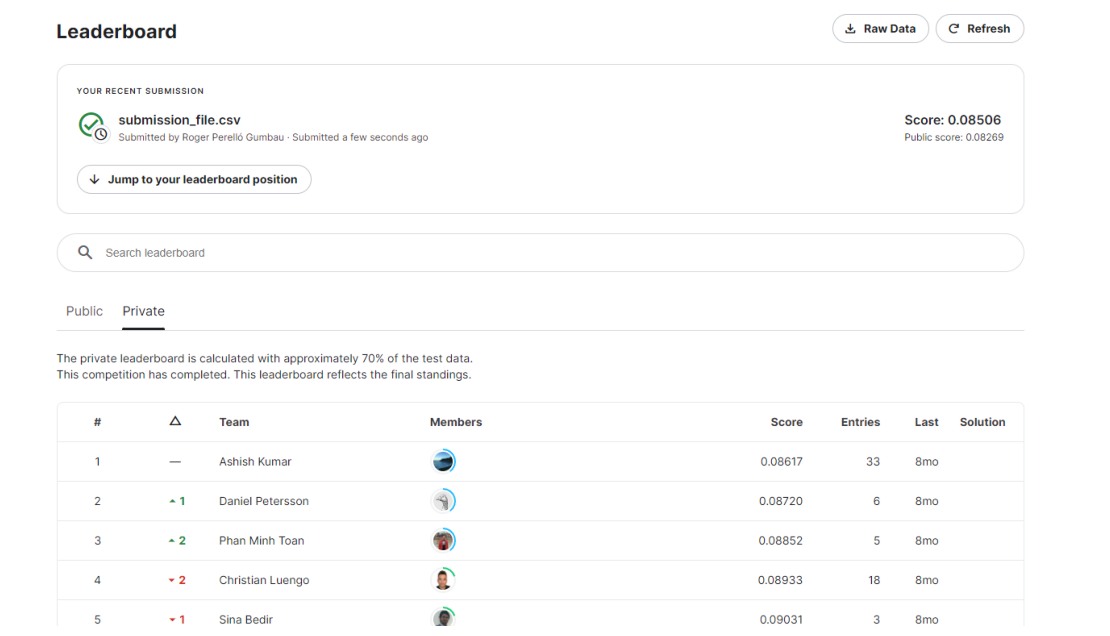

In [ ]:
# Se recibe la puntuación final
plt.rc("figure", figsize=(16, 8))

img = mpimg.imread(r'kaggle_submission\result.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


# Mejoras para visualización

- Como en el "dataframe" sobre las imágenes no hay datos sobre la "table", toca repetir el proceso pero, esta vez, sin la columna "table (percentage)" con tal de poder relacionar los dos modelos (el de detección de características a través de las imágenes y el de predicción de precios)

- Sin embargo, los datos son de mayo de 2017. Por tanto, en el momento de mostrar el precio predicho en la "app" habrá que ajustarlo por la inflación (fuente: https://www.diamondse.info/diamonds-price-index.asp)

In [28]:
df_visualizacion = df_cambios.copy()

df_visualizacion = df_visualizacion.drop(columns=['table (percentage)'])

df_visualizacion.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
id,,,,,,,,,
0,0.30,3.0,6.0,1.0,62.4,4.31,4.28,2.68,6.353
1,1.01,4.0,5.0,5.0,62.7,6.42,6.46,4.04,9.183
2,0.72,4.0,4.0,3.0,61.8,5.71,5.74,3.54,7.983
3,1.08,2.0,3.0,1.0,63.2,6.54,6.50,4.12,8.371
4,0.36,3.0,3.0,4.0,62.3,4.50,4.55,2.82,6.588


In [29]:
visualizacion = Regression(df_visualizacion, 'price')
X_train, X_test, y_train, y_test = visualizacion.split_dataframe()

X_train.head()

,weight (carat),cut quality,color quality,clarity quality,depth (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
id,,,,,,,,
7600,0.41,1.0,0.0,7.0,63.6,4.72,4.75,3.01
11480,0.51,1.0,2.0,1.0,56.7,5.38,5.35,3.04
22230,0.36,1.0,4.0,4.0,63.6,4.52,4.47,2.86
1718,1.24,4.0,2.0,6.0,62.3,6.88,6.90,4.29
21329,0.40,2.0,6.0,2.0,62.5,4.66,4.69,2.92


## Ronda visualización 1: solo cambios

- Esta ronda solo sirve como referencia

- Al quitar esa columna, la predicción empeora un poco, pero no demasiado

In [6]:
df_visualizacion = df_cambios.copy()

df_visualizacion = df_visualizacion.drop(columns=['table (percentage)'])

round_vis_1 = Regression(df_visualizacion, 'price')
X_train, X_test, y_train, y_test = round_vis_1.split_dataframe()
round_vis_1.prepare_models(params_list=[['XGBRegressor', 'random_state=43']])
round_vis_1.apply_and_evaluate_kfolds()
round_vis_1.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 6.36 sec(s). Total time: 6.36


,XGBRegressor: random_state=43
mae,0.066048
mape,0.008519
mse,0.008335
r2_score,0.991921
rmse,0.091279


## Ronda visualización 2: "eta"

In [13]:
model = XGBRegressor(booster='gbtree', n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:5.15340
[1]	validation_0-rmse:3.61090
[2]	validation_0-rmse:2.53117
[3]	validation_0-rmse:1.77563
[4]	validation_0-rmse:1.24698
[5]	validation_0-rmse:0.87780
[6]	validation_0-rmse:0.62082
[7]	validation_0-rmse:0.44253
[8]	validation_0-rmse:0.32015
[9]	validation_0-rmse:0.23727
[10]	validation_0-rmse:0.18311
[11]	validation_0-rmse:0.14889
[12]	validation_0-rmse:0.12842
[13]	validation_0-rmse:0.11643
[14]	validation_0-rmse:0.10959
[15]	validation_0-rmse:0.10540
[16]	validation_0-rmse:0.10334
[17]	validation_0-rmse:0.10199
[18]	validation_0-rmse:0.10100
[19]	validation_0-rmse:0.09996
[20]	validation_0-rmse:0.09948
[21]	validation_0-rmse:0.09913
[22]	validation_0-rmse:0.09854
[23]	validation_0-rmse:0.09820
[24]	validation_0-rmse:0.09783
[25]	validation_0-rmse:0.09737
[26]	validation_0-rmse:0.09717
[27]	validation_0-rmse:0.09692
[28]	validation_0-rmse:0.09664
[29]	validation_0-rmse:0.09656
[30]	validation_0-rmse:0.09639
[31]	validation_0-rmse:0.09593
[32]	validation_0-

172

In [14]:
model = XGBRegressor()

params = {'random_state': [43],
          'booster': ['gbtree'],
          'n_estimators': [171],
          'eta': [0.75, 0.1, 0.125, 0.15, 0.175],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=gbtree, eta=0.75, n_estimators=171, random_state=43;, score=-0.109 total time=   2.0s
[CV 2/5] END booster=gbtree, eta=0.75, n_estimators=171, random_state=43;, score=-0.106 total time=   1.6s
[CV 3/5] END booster=gbtree, eta=0.75, n_estimators=171, random_state=43;, score=-0.101 total time=   1.4s
[CV 4/5] END booster=gbtree, eta=0.75, n_estimators=171, random_state=43;, score=-0.101 total time=   1.6s
[CV 5/5] END booster=gbtree, eta=0.75, n_estimators=171, random_state=43;, score=-0.101 total time=   1.8s
[CV 1/5] END booster=gbtree, eta=0.1, n_estimators=171, random_state=43;, score=-0.092 total time=   2.6s
[CV 2/5] END booster=gbtree, eta=0.1, n_estimators=171, random_state=43;, score=-0.091 total time=   1.9s
[CV 3/5] END booster=gbtree, eta=0.1, n_estimators=171, random_state=43;, score=-0.088 total time=   1.8s
[CV 4/5] END booster=gbtree, eta=0.1, n_estimators=171, random_state=43;, score=-0.088 

In [15]:
model = XGBRegressor(booster='gbtree', eta=0.15, n_estimators=2000)

model.early_stopping_rounds = 500

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.25481
[1]	validation_0-rmse:5.31758
[2]	validation_0-rmse:4.52146
[3]	validation_0-rmse:3.84486
[4]	validation_0-rmse:3.26999
[5]	validation_0-rmse:2.78099
[6]	validation_0-rmse:2.36548
[7]	validation_0-rmse:2.01256
[8]	validation_0-rmse:1.71259
[9]	validation_0-rmse:1.45772
[10]	validation_0-rmse:1.24104
[11]	validation_0-rmse:1.05718
[12]	validation_0-rmse:0.90112
[13]	validation_0-rmse:0.76859
[14]	validation_0-rmse:0.65630
[15]	validation_0-rmse:0.56107
[16]	validation_0-rmse:0.48058
[17]	validation_0-rmse:0.41249
[18]	validation_0-rmse:0.35531
[19]	validation_0-rmse:0.30727
[20]	validation_0-rmse:0.26704
[21]	validation_0-rmse:0.23364
[22]	validation_0-rmse:0.20600
[23]	validation_0-rmse:0.18311
[24]	validation_0-rmse:0.16469
[25]	validation_0-rmse:0.14972
[26]	validation_0-rmse:0.13777
[27]	validation_0-rmse:0.12852
[28]	validation_0-rmse:0.12130
[29]	validation_0-rmse:0.11557
[30]	validation_0-rmse:0.11107
[31]	validation_0-rmse:0.10775
[32]	validation_0-

374

## Ronda visualización 3: "constraints"

- Como se ha visto que solo puede mejorar con "weight", se comprueba únicamente si realmente sigue ocurriendo con esa columna

In [16]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [373],
          'booster': ['gbtree'],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43;, score=-0.089 total time=   7.4s
[CV 2/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43;, score=-0.090 total time=   5.5s
[CV 3/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43;, score=-0.087 total time=   4.9s
[CV 4/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43;, score=-0.087 total time=   5.2s
[CV 5/5] END booster=gbtree, eta=0.15, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43;, score=-0.088 total time=   6.4s
Best params: {'booster': 'gbtree', 'eta': 0.15, 'monotone_constraints': {'weight (carat)': 1}, 'n_estimators': 373, 'random_state': 43}
Best score: -0.08818331545044364


## Ronda visualización 4: "max_depth" y "min_child_weight"

In [18]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [373],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': range(4, 11),
          'min_child_weight': range(1, 9)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.092 total time=   4.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.091 total time=   4.8s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.089 total time=   6.6s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, max_depth=4, min_child_weight=1, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.088 total time=   6.4s
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, eta

## Ronda visualización 5: "gamma"

In [21]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [373],
          'eta': [0.15],
          'booster': ['gbtree'],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample':[0.8],
          'colsample_bytree': [0.8],
          'max_depth': [6],
          'min_child_weight': [2],
          'gamma': np.linspace(0, 1, num=11)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.090 total time=   8.9s
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.089 total time=   6.8s
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.087 total time=   5.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, eta=0.15, gamma=0.0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.8;, score=-0.087 total time=   5.2s
[CV 5/5] EN

## Ronda visualización 6: "sampling"

In [7]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [373],
          'booster': ['gbtree'],
          'eta': [0.15],
          'max_depth': [6],
          'min_child_weight': [2],
          'monotone_constraints':[{"weight (carat)": 1}],
          'gamma': [0],
          'subsample': np.linspace(0.5, 1.0, num=6),
          'colsample_bytree': np.linspace(0.5, 1.0, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.5;, score=-0.093 total time=   8.1s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.5;, score=-0.091 total time=   6.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.5;, score=-0.089 total time=   6.3s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eta=0.15, gamma=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, subsample=0.5;, score=-0.088 total time=   7.7s
[CV 5/5] END boost

## Ronda visualización 7: hiperparámetros de regularización

In [8]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [373],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.9],
          'colsample_bytree': [0.7],
          'max_depth': [6],
          'min_child_weight': [2],
          'gamma': [0],
          'max_delta_step': range(0, 6),
          'lambda': np.linspace(0, 1, num=6),
          'reg_alpha': np.linspace(0, 1, num=6)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, reg_alpha=0.0, subsample=0.9;, score=-0.091 total time=   5.9s
[CV 2/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, reg_alpha=0.0, subsample=0.9;, score=-0.090 total time=   6.8s
[CV 3/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, random_state=43, reg_alpha=0.0, subsample=0.9;, score=-0.087 total time=   6.8s
[CV 4/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.0, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}

## Ronda visualización 8: "num_parallel_tree"

In [10]:
model = XGBRegressor()

params = {'random_state': [43],
          'n_estimators': [373],
          'eta': [0.15],
          'monotone_constraints':[{"weight (carat)": 1}],
          'subsample': [0.9],
          'colsample_bytree': [0.7],
          'max_depth': [6],
          'min_child_weight': [2],
          'max_delta_step': [0],
          'gamma': [0],
          'lambda': [0.8],
          'reg_alpha': [1],
          'num_parallel_tree': range(6, 13)
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.8, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, num_parallel_tree=6, random_state=43, reg_alpha=1, subsample=0.9;, score=-0.090 total time=  32.2s
[CV 2/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.8, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, num_parallel_tree=6, random_state=43, reg_alpha=1, subsample=0.9;, score=-0.088 total time=  31.8s
[CV 3/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.8, max_delta_step=0, max_depth=6, min_child_weight=2, monotone_constraints={'weight (carat)': 1}, n_estimators=373, num_parallel_tree=6, random_state=43, reg_alpha=1, subsample=0.9;, score=-0.085 total time=  31.9s
[CV 4/5] END colsample_bytree=0.7, eta=0.15, gamma=0, lambda=0.8, max_delta_step=0, max_depth=6, min_child

## Ronda visualización 9: reajuste de estimadores

In [12]:
model = XGBRegressor(n_estimators=2000, 
                        eta=0.15,
                        monotone_constraints={"weight (carat)": 1}, 
                        subsample=0.9, 
                        colsample_bytree=0.7, 
                        max_depth=6, 
                        min_child_weight=2, 
                        max_delta_step=0,
                        gamma=0,
                        reg_lambda=0.8,
                        reg_alpha=1,
                        num_parallel_tree=10
                    )

model.early_stopping_rounds = 300

model.fit(X_train, y_train, eval_set=[(X_test, y_test)]) 

model.best_ntree_limit


[0]	validation_0-rmse:6.25445
[1]	validation_0-rmse:5.31781
[2]	validation_0-rmse:4.52194
[3]	validation_0-rmse:3.84519
[4]	validation_0-rmse:3.27015
[5]	validation_0-rmse:2.78139
[6]	validation_0-rmse:2.36616
[7]	validation_0-rmse:2.01328
[8]	validation_0-rmse:1.71334
[9]	validation_0-rmse:1.45875
[10]	validation_0-rmse:1.24251
[11]	validation_0-rmse:1.05884
[12]	validation_0-rmse:0.90296
[13]	validation_0-rmse:0.77071
[14]	validation_0-rmse:0.65843
[15]	validation_0-rmse:0.56364
[16]	validation_0-rmse:0.48356
[17]	validation_0-rmse:0.41577
[18]	validation_0-rmse:0.35880
[19]	validation_0-rmse:0.31099
[20]	validation_0-rmse:0.27107
[21]	validation_0-rmse:0.23783
[22]	validation_0-rmse:0.21048
[23]	validation_0-rmse:0.18776
[24]	validation_0-rmse:0.16924
[25]	validation_0-rmse:0.15426
[26]	validation_0-rmse:0.14217
[27]	validation_0-rmse:0.13254
[28]	validation_0-rmse:0.12490
[29]	validation_0-rmse:0.11907
[30]	validation_0-rmse:0.11445
[31]	validation_0-rmse:0.11086
[32]	validation_0-

8260

# Resolución de visualización

- Se lleva a cabo la predicción de prueba. A priori, el resultado es incluso mejor que el de la competición

- Se sube "Kaggle" para comprobarlo y la puntuación es peor, así que se descarta en ese sentido. Sin embargo, como ocuparía una segunda posición, se da por válido para predecir el precio de los diamantes de las fotos con un margen de error razonable

In [15]:
# Se lleva a cabo la predicción de prueba. A priori, el resultado es incluso mejor que el de la competición
model = XGBRegressor(n_estimators=825, 
                        eta=0.15,
                        monotone_constraints={"weight (carat)": 1}, 
                        subsample=0.9, 
                        colsample_bytree=0.7, 
                        max_depth=6, 
                        min_child_weight=2, 
                        max_delta_step=0,
                        gamma=0,
                        reg_lambda=0.8,
                        reg_alpha=1,
                        num_parallel_tree=10,
                    )

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)


0.08576829386528399

In [19]:
# Se prueba con enviarla a Kaggle por si realmente mejora el resultado
prediction = model.predict(df_predict.drop(columns='table (percentage)'))

submission = pd.DataFrame({"id": range(len(prediction)), 'price': prediction})

submission.to_csv(r'kaggle_submission\submission_file_2.csv', index=False)


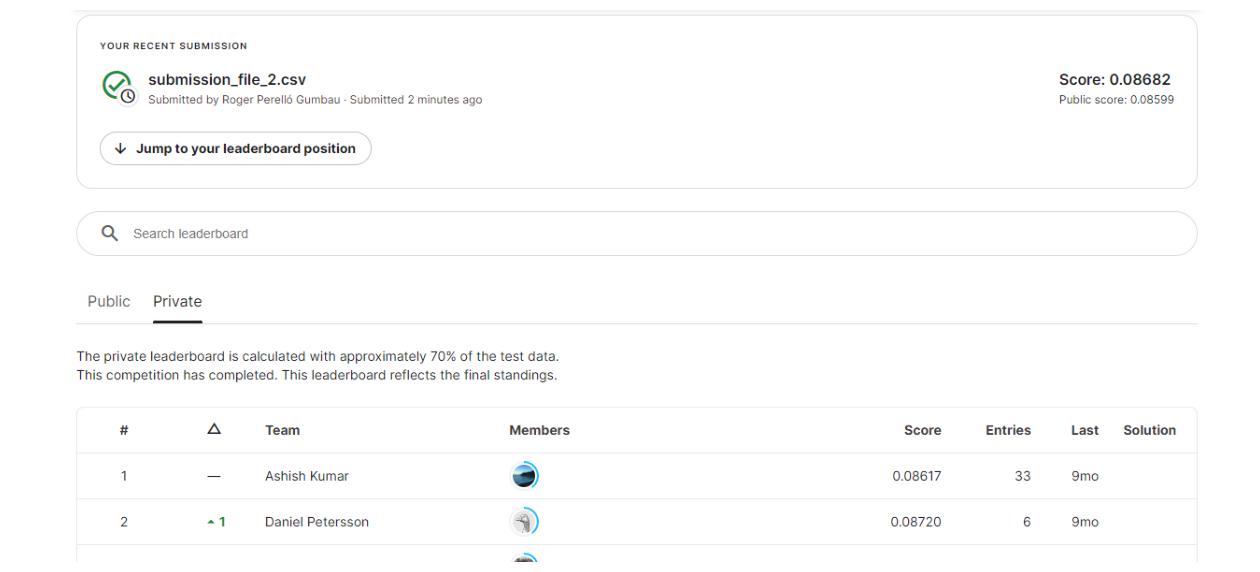

In [20]:
# Sin embargo, es algo peor que el anterior
plt.rc("figure", figsize=(16, 8))

img = mpimg.imread(r'kaggle_submission\bad_result.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
